In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/dataset

/content/drive/MyDrive/dataset


In [ ]:
import os
import cv2
import time
import random
import colorsys
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, LeakyReLU, ZeroPadding2D, BatchNormalization
from tensorflow.keras.regularizers import l2
from google.colab.patches import cv2_imshow


config 설정



In [ ]:
# YOLO options
YOLO_DARKNET_WEIGHTS        = "./model_data/yolov3.weights"
YOLO_COCO_CLASSES           = "./model_data/coco.names"
YOLO_STRIDES                = [8, 16, 32]
YOLO_IOU_LOSS_THRESH        = 0.5
YOLO_INPUT_SIZE             = 416
YOLO_ANCHORS                = [[[10,  13], [16,   30], [33,   23]],
                               [[30,  61], [62,   45], [59,  119]],
                               [[116, 90], [156, 198], [373, 326]]]

In [ ]:
def read_class_names(class_file_name):
    # loads class name from a file
    names = {}
    with open(class_file_name, 'r') as data:
        for ID, name in enumerate(data):
            names[ID] = name.strip('\n')
    return names

In [ ]:
NUM_CLASS = read_class_names(YOLO_COCO_CLASSES)
NUM_CLASS

{0: 'person',
 1: 'bicycle',
 2: 'car',
 3: 'motorbike',
 4: 'aeroplane',
 5: 'bus',
 6: 'train',
 7: 'truck',
 8: 'boat',
 9: 'traffic light',
 10: 'fire hydrant',
 11: 'stop sign',
 12: 'parking meter',
 13: 'bench',
 14: 'bird',
 15: 'cat',
 16: 'dog',
 17: 'horse',
 18: 'sheep',
 19: 'cow',
 20: 'elephant',
 21: 'bear',
 22: 'zebra',
 23: 'giraffe',
 24: 'backpack',
 25: 'umbrella',
 26: 'handbag',
 27: 'tie',
 28: 'suitcase',
 29: 'frisbee',
 30: 'skis',
 31: 'snowboard',
 32: 'sports ball',
 33: 'kite',
 34: 'baseball bat',
 35: 'baseball glove',
 36: 'skateboard',
 37: 'surfboard',
 38: 'tennis racket',
 39: 'bottle',
 40: 'wine glass',
 41: 'cup',
 42: 'fork',
 43: 'knife',
 44: 'spoon',
 45: 'bowl',
 46: 'banana',
 47: 'apple',
 48: 'sandwich',
 49: 'orange',
 50: 'broccoli',
 51: 'carrot',
 52: 'hot dog',
 53: 'pizza',
 54: 'donut',
 55: 'cake',
 56: 'chair',
 57: 'sofa',
 58: 'pottedplant',
 59: 'bed',
 60: 'diningtable',
 61: 'toilet',
 62: 'tvmonitor',
 63: 'laptop',
 64: 

In [ ]:
def image_preprocess(image, target_size):
    ih, iw    = target_size
    h,  w, _  = image.shape

    scale = min(iw/w, ih/h)
    nw, nh  = int(scale * w), int(scale * h)
    image_resized = cv2.resize(image, (nw, nh))

    image_paded = np.full(shape=[ih, iw, 3], fill_value=128.0)
    dw, dh = (iw - nw) // 2, (ih-nh) // 2
    image_paded[dh:nh+dh, dw:nw+dw, :] = image_resized
    image_paded = image_paded / 255.

    return image_paded

original: (437, 731, 3)
resized: (416, 416, 3)


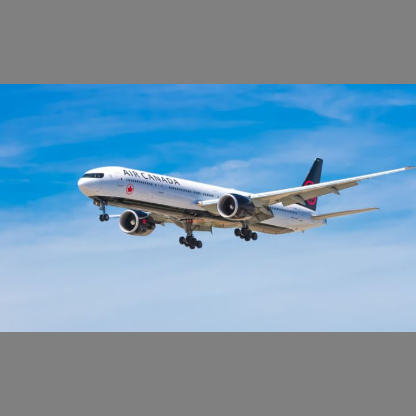

In [ ]:
image_path ="./airplane.jpg"
input_size = 416
original_image      = cv2.imread(image_path)


print("original:",original_image.shape)

image_data = image_preprocess(np.copy(original_image), [input_size, input_size])
print("resized:",image_data.shape)
cv2_imshow(image_data*255)

In [ ]:
def draw_bbox(image, bboxes, CLASSES=YOLO_COCO_CLASSES, show_label=True, show_confidence = True, Text_colors=(0,0,0), rectangle_colors=''):   
    NUM_CLASS = read_class_names(CLASSES)
    num_classes = len(NUM_CLASS)
    image_h, image_w, _ = image.shape

    hsv_tuples = [(1.0 * x / num_classes, 1., 1.) for x in range(num_classes)]
    
    #print("hsv_tuples", hsv_tuples)
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), colors))

    random.seed(0)
    random.shuffle(colors)
    random.seed(None)

    for i, bbox in enumerate(bboxes):
        coor = np.array(bbox[:4], dtype=np.int32)
        score = bbox[4]
        class_ind = int(bbox[5])
        bbox_color = rectangle_colors if rectangle_colors != ''else colors[class_ind]
        bbox_thick = int(0.6 * (image_h + image_w) / 1000)
        if bbox_thick < 1: bbox_thick = 1
        #print(image_h, image_w, bbox_thick)
        fontScale = 0.75 * bbox_thick
        (x1, y1), (x2, y2) = (coor[0], coor[1]), (coor[2], coor[3])

        # put object rectangle
        cv2.rectangle(image, (x1, y1), (x2, y2), bbox_color, bbox_thick*2)

        if show_label:
            # get text label
            score_str = f' {score:.2f}' if show_confidence else '' 
            label = f'{NUM_CLASS[class_ind]}' + score_str

            # get text size
            (text_width, text_height), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_COMPLEX_SMALL,
                                                                  fontScale, thickness=bbox_thick)
            # put filled text rectangle
            cv2.rectangle(image, (x1, y1), (x1 + text_width, y1 - text_height - baseline), bbox_color, thickness=cv2.FILLED)

            # put text above rectangle
            cv2.putText(image, label, (x1, y1-4), cv2.FONT_HERSHEY_COMPLEX_SMALL,
                        fontScale, Text_colors, bbox_thick, lineType=cv2.LINE_AA)

    return image

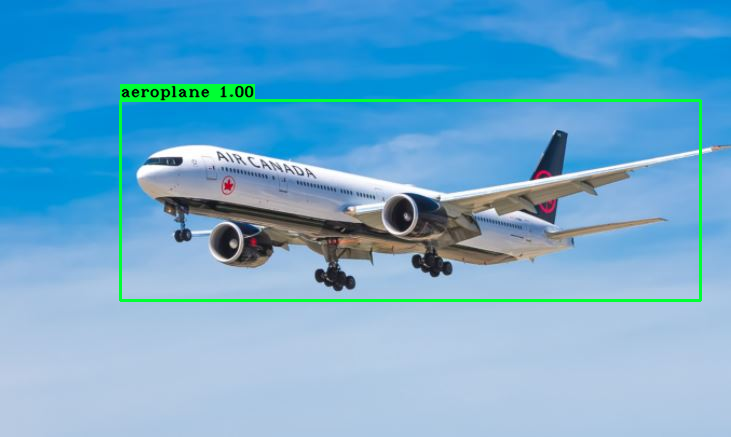

In [ ]:
# image = draw_bbox(original_image, bboxes, CLASSES=CLASSES, rectangle_colors=rectangle_colors)

bboxes = [[120,100,700,300,1.0, 4]]

img = draw_bbox(original_image, bboxes, YOLO_COCO_CLASSES, show_label=True, show_confidence = True,rectangle_colors='' )

cv2_imshow(img)

In [ ]:
def bboxes_iou(boxes1, boxes2):
    boxes1 = np.array(boxes1)
    boxes2 = np.array(boxes2)


    boxes1_area = (boxes1[..., 2] - boxes1[..., 0]) * (boxes1[..., 3] - boxes1[..., 1])
    boxes2_area = (boxes2[..., 2] - boxes2[..., 0]) * (boxes2[..., 3] - boxes2[..., 1])

    left_up       = np.maximum(boxes1[..., :2], boxes2[..., :2])
    right_down    = np.minimum(boxes1[..., 2:], boxes2[..., 2:])

    inter_section = np.maximum(right_down - left_up, 0.0)
    inter_area    = inter_section[..., 0] * inter_section[..., 1]
    union_area    = boxes1_area + boxes2_area - inter_area
    ious          = np.maximum(1.0 * inter_area / union_area, np.finfo(np.float32).eps)

    return ious

In [ ]:
boxes1=[100,100,200,200]  # 10000
boxes2=[120,120,220,220]  # 10000     - 6400 = 6400/(20000-6400)

print(bboxes_iou(boxes1, boxes2))

0.47058823529411764


In [ ]:
def nms(bboxes, iou_threshold):
    """
    bboxes: (xmin, ymin, xmax, ymax, score, class)
    """
    classes_in_img = list(set(bboxes[:, 5]))
    best_bboxes = []

    for cls in classes_in_img:
        cls_mask = (bboxes[:, 5] == cls)
        cls_bboxes = bboxes[cls_mask]
        # Process 1: Determine whether the number of bounding boxes is greater than 0 
        while len(cls_bboxes) > 0:
            # Process 2: Select the bounding box with the highest score according to socre order A
            max_ind = np.argmax(cls_bboxes[:, 4])
            best_bbox = cls_bboxes[max_ind]
            best_bboxes.append(best_bbox)
            cls_bboxes = np.concatenate([cls_bboxes[: max_ind], cls_bboxes[max_ind + 1:]])
            # Process 3: Calculate this bounding box A and
            # Remain all iou of the bounding box and remove those bounding boxes whose iou value is higher than the threshold 
            iou = bboxes_iou(best_bbox[np.newaxis, :4], cls_bboxes[:, :4])
            weight = np.ones((len(iou),), dtype=np.float32)

            iou_mask = iou > iou_threshold
            weight[iou_mask] = 0.0

            cls_bboxes[:, 4] = cls_bboxes[:, 4] * weight
            score_mask = cls_bboxes[:, 4] > 0.
            cls_bboxes = cls_bboxes[score_mask]

    return best_bboxes

In [ ]:
bboxes = [
          [10,10,100,100, 0.9, 1],
           [20,20,120,120, 0.8, 1],
           [50,50,150,150, 0.7, 1],
           [10,10,120,120, 0.6, 2],
           [30,30,140,140, 0.9, 2],
          ]

bboxes=  np.array(bboxes)
best_bboxes = nms(bboxes, iou_threshold=0.45)

best_bboxes

[array([ 10. ,  10. , 100. , 100. ,   0.9,   1. ]),
 array([ 50. ,  50. , 150. , 150. ,   0.7,   1. ]),
 array([ 30. ,  30. , 140. , 140. ,   0.9,   2. ])]

In [ ]:
def postprocess_boxes(pred_bbox, original_image, input_size, score_threshold):
    valid_scale=[0, np.inf]
    pred_bbox = np.array(pred_bbox)

    pred_xywh = pred_bbox[:, 0:4]
    pred_conf = pred_bbox[:, 4]
    pred_prob = pred_bbox[:, 5:]

    # 1. (x, y, w, h) --> (xmin, ymin, xmax, ymax)
    pred_coor = np.concatenate([pred_xywh[:, :2] - pred_xywh[:, 2:] * 0.5,
                                pred_xywh[:, :2] + pred_xywh[:, 2:] * 0.5], axis=-1)
    
    # 2. (xmin, ymin, xmax, ymax) -> (xmin_org, ymin_org, xmax_org, ymax_org)
    org_h, org_w = original_image.shape[:2]
    resize_ratio = min(input_size / org_w, input_size / org_h)

    dw = (input_size - resize_ratio * org_w) / 2
    dh = (input_size - resize_ratio * org_h) / 2

    pred_coor[:, 0::2] = 1.0 * (pred_coor[:, 0::2] - dw) / resize_ratio
    pred_coor[:, 1::2] = 1.0 * (pred_coor[:, 1::2] - dh) / resize_ratio

    # 3. clip some boxes those are out of range
    pred_coor = np.concatenate([np.maximum(pred_coor[:, :2], [0, 0]),
                                np.minimum(pred_coor[:, 2:], [org_w - 1, org_h - 1])], axis=-1)
    invalid_mask = np.logical_or((pred_coor[:, 0] > pred_coor[:, 2]), (pred_coor[:, 1] > pred_coor[:, 3]))
    pred_coor[invalid_mask] = 0

    # 4. discard some invalid boxes
    bboxes_scale = np.sqrt(np.multiply.reduce(pred_coor[:, 2:4] - pred_coor[:, 0:2], axis=-1))
    scale_mask = np.logical_and((valid_scale[0] < bboxes_scale), (bboxes_scale < valid_scale[1]))

    # 5. discard boxes with low scores
    classes = np.argmax(pred_prob, axis=-1)
    scores = pred_conf * pred_prob[np.arange(len(pred_coor)), classes]
    score_mask = scores > score_threshold
    mask = np.logical_and(scale_mask, score_mask)
    coors, scores, classes = pred_coor[mask], scores[mask], classes[mask]

    return np.concatenate([coors, scores[:, np.newaxis], classes[:, np.newaxis]], axis=-1)

In [ ]:
pred_bbox = [
           [10,10,100,100, 0.9, 0,3,0.7],
           [20,20,120,120, 0.8, 0,5,0.5],
           [50,50,150,150, 0.7, 0,4,0.6],
           [10,10,120,120, 0.6, 0,3,0.7],
           [30,30,140,140, 0.9, 0,9,0.1],
          ]

pred_bbox=  np.array(pred_bbox)
results = postprocess_boxes(pred_bbox,original_image,input_size=416,score_threshold=0.3)
results[0]

array([  0.        ,   0.        , 219.65144231,  72.65144231,
         2.8       ,   1.        ])

In [ ]:
def detect_image(YoloV3, image_path, output_path, input_size=416, show=False, CLASSES=YOLO_COCO_CLASSES, score_threshold=0.3, iou_threshold=0.45, rectangle_colors=''):  #iou_threshold=0.45
    original_image      = cv2.imread(image_path)
    # original_image      = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    # original_image      = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    image_data = image_preprocess(np.copy(original_image), [input_size, input_size])
    image_data = tf.expand_dims(image_data, 0)

    pred_bbox = YoloV3.predict(image_data)
    pred_bbox = [tf.reshape(x, (-1, tf.shape(x)[-1])) for x in pred_bbox]
    pred_bbox = tf.concat(pred_bbox, axis=0)
    
    bboxes = postprocess_boxes(pred_bbox, original_image, input_size, score_threshold)
    bboxes = nms(bboxes, iou_threshold)

    image = draw_bbox(original_image, bboxes, CLASSES=CLASSES, rectangle_colors=rectangle_colors)
    #cv2.imwrite('./output2.jpg', image)
    return image



YOLO V3 Model

In [ ]:

STRIDES         = np.array(YOLO_STRIDES)
ANCHORS         = (np.array(YOLO_ANCHORS).T/STRIDES).T
IOU_LOSS_THRESH = YOLO_IOU_LOSS_THRESH

class BatchNormalization(BatchNormalization):
    # "Frozen state" and "inference mode" are two separate concepts.
    # `layer.trainable = False` is to freeze the layer, so the layer will use
    # stored moving `var` and `mean` in the "inference mode", and both `gama`
    # and `beta` will not be updated !
    def call(self, x, training=False):
        if not training:
            training = tf.constant(False)
        training = tf.logical_and(training, self.trainable)
        return super().call(x, training)

def convolutional(input_layer, filters_shape, downsample=False, activate=True, bn=True):
    if downsample:
        input_layer = ZeroPadding2D(((1, 0), (1, 0)))(input_layer)
        padding = 'valid'
        strides = 2
    else:
        strides = 1
        padding = 'same'

    conv = Conv2D(filters=filters_shape[-1], kernel_size = filters_shape[0], strides=strides,
                  padding=padding, use_bias=not bn, kernel_regularizer=l2(0.0005),
                  kernel_initializer=tf.random_normal_initializer(stddev=0.01),
                  bias_initializer=tf.constant_initializer(0.))(input_layer)
    if bn:
        conv = BatchNormalization()(conv)
    if activate == True:
        conv = LeakyReLU(alpha=0.1)(conv)

    return conv

def residual_block(input_layer, input_channel, filter_num1, filter_num2):
    short_cut = input_layer
    conv = convolutional(input_layer, filters_shape=(1, 1, input_channel, filter_num1))
    conv = convolutional(conv       , filters_shape=(3, 3, filter_num1,   filter_num2))

    residual_output = short_cut + conv
    return residual_output

def upsample(input_layer):
    return tf.image.resize(input_layer, (input_layer.shape[1] * 2, input_layer.shape[2] * 2), method='nearest')


def darknet53(input_data):
    input_data = convolutional(input_data, (3, 3,  3,  32))
    input_data = convolutional(input_data, (3, 3, 32,  64), downsample=True)

    for i in range(1):
        input_data = residual_block(input_data,  64,  32, 64)

    input_data = convolutional(input_data, (3, 3,  64, 128), downsample=True)

    for i in range(2):
        input_data = residual_block(input_data, 128,  64, 128)

    input_data = convolutional(input_data, (3, 3, 128, 256), downsample=True)

    for i in range(8):
        input_data = residual_block(input_data, 256, 128, 256)

    route_1 = input_data
    input_data = convolutional(input_data, (3, 3, 256, 512), downsample=True)

    for i in range(8):
        input_data = residual_block(input_data, 512, 256, 512)

    route_2 = input_data
    input_data = convolutional(input_data, (3, 3, 512, 1024), downsample=True)

    for i in range(4):
        input_data = residual_block(input_data, 1024, 512, 1024)

    return route_1, route_2, input_data

def YOLOv3(input_layer, NUM_CLASS):
    # the Darknet-53 네트워크로부터 3개의 branch
    route_1, route_2, conv = darknet53(input_layer)

    # 5 회 convolution 연산
    conv = convolutional(conv, (1, 1, 1024,  512))
    conv = convolutional(conv, (3, 3,  512, 1024))
    conv = convolutional(conv, (1, 1, 1024,  512))
    conv = convolutional(conv, (3, 3,  512, 1024))
    conv = convolutional(conv, (1, 1, 1024,  512))
    
    conv_lobj_branch = convolutional(conv, (3, 3, 512, 1024))
    
    # conv_lbbox is used to predict large-sized objects , Shape = [None, 13, 13, 255] 
    conv_lbbox = convolutional(conv_lobj_branch, (1, 1, 1024, 3*(NUM_CLASS + 5)), activate=False, bn=False)

    conv = convolutional(conv, (1, 1,  512,  256))
    # upsample here uses the nearest neighbor interpolation method, which has the advantage that the
    # upsampling process does not need to learn, thereby reducing the network parameter  
    conv = upsample(conv)

    conv = tf.concat([conv, route_2], axis=-1)
    conv = convolutional(conv, (1, 1, 768, 256))
    conv = convolutional(conv, (3, 3, 256, 512))
    conv = convolutional(conv, (1, 1, 512, 256))
    conv = convolutional(conv, (3, 3, 256, 512))
    conv = convolutional(conv, (1, 1, 512, 256))
    conv_mobj_branch = convolutional(conv, (3, 3, 256, 512))

    # conv_mbbox is used to predict medium-sized objects, shape = [None, 26, 26, 255]
    conv_mbbox = convolutional(conv_mobj_branch, (1, 1, 512, 3*(NUM_CLASS + 5)), activate=False, bn=False)

    conv = convolutional(conv, (1, 1, 256, 128))
    conv = upsample(conv)

    conv = tf.concat([conv, route_1], axis=-1)
    conv = convolutional(conv, (1, 1, 384, 128))
    conv = convolutional(conv, (3, 3, 128, 256))
    conv = convolutional(conv, (1, 1, 256, 128))
    conv = convolutional(conv, (3, 3, 128, 256))
    conv = convolutional(conv, (1, 1, 256, 128))
    conv_sobj_branch = convolutional(conv, (3, 3, 128, 256))
    
    # conv_sbbox is used to predict small size objects, shape = [None, 52, 52, 255]
    conv_sbbox = convolutional(conv_sobj_branch, (1, 1, 256, 3*(NUM_CLASS +5)), activate=False, bn=False)
        
    return [conv_sbbox, conv_mbbox, conv_lbbox]

def Create_Yolov3(input_size=416, channels=3, training=False, CLASSES=YOLO_COCO_CLASSES):
    NUM_CLASS = len(read_class_names(CLASSES))
    input_layer  = Input([input_size, input_size, channels])

    conv_tensors = YOLOv3(input_layer, NUM_CLASS)

    output_tensors = []
    for i, conv_tensor in enumerate(conv_tensors):
        pred_tensor = decode(conv_tensor, NUM_CLASS, i)
        if training: output_tensors.append(conv_tensor)
        output_tensors.append(pred_tensor)

    YoloV3 = tf.keras.Model(input_layer, output_tensors)
    return YoloV3

def decode(conv_output, NUM_CLASS, i=0):
    # where i = 0, 1 or 2 to correspond to the three grid scales  
    conv_shape       = tf.shape(conv_output)
    batch_size       = conv_shape[0]
    output_size      = conv_shape[1]

    conv_output = tf.reshape(conv_output, (batch_size, output_size, output_size, 3, 5 + NUM_CLASS))

    conv_raw_dxdy = conv_output[:, :, :, :, 0:2] # offset of center position     
    conv_raw_dwdh = conv_output[:, :, :, :, 2:4] # Prediction box length and width offset
    conv_raw_conf = conv_output[:, :, :, :, 4:5] # confidence of the prediction box
    conv_raw_prob = conv_output[:, :, :, :, 5: ] # category probability of the prediction box 

    # next need Draw the grid. Where output_size is equal to 13, 26 or 52  
    y = tf.range(output_size, dtype=tf.int32)
    y = tf.expand_dims(y, -1)
    y = tf.tile(y, [1, output_size])
    x = tf.range(output_size,dtype=tf.int32)
    x = tf.expand_dims(x, 0)
    x = tf.tile(x, [output_size, 1])

    xy_grid = tf.concat([x[:, :, tf.newaxis], y[:, :, tf.newaxis]], axis=-1)
    xy_grid = tf.tile(xy_grid[tf.newaxis, :, :, tf.newaxis, :], [batch_size, 1, 1, 3, 1])
    xy_grid = tf.cast(xy_grid, tf.float32)

    # Calculate the center position of the prediction box:
    pred_xy = (tf.sigmoid(conv_raw_dxdy) + xy_grid) * STRIDES[i]
    # Calculate the length and width of the prediction box:
    pred_wh = (tf.exp(conv_raw_dwdh) * ANCHORS[i]) * STRIDES[i]

    pred_xywh = tf.concat([pred_xy, pred_wh], axis=-1)
    pred_conf = tf.sigmoid(conv_raw_conf) # object box calculates the predicted confidence
    pred_prob = tf.sigmoid(conv_raw_prob) # calculating the predicted probability category box object

    # calculating the predicted probability category box object
    return tf.concat([pred_xywh, pred_conf, pred_prob], axis=-1)


In [ ]:
def load_yolo_weights(model, weights_file):
    print('load yolo weight called')
    tf.keras.backend.clear_session() # used to reset layer names
    # load Darknet original weights to TensorFlow model
 
    range1 = 75 
    range2 = [58, 66, 74] 
    
    with open(weights_file, 'rb') as wf:
        major, minor, revision, seen, _ = np.fromfile(wf, dtype=np.int32, count=5)

        j = 0
        for i in range(range1):
            if i > 0:
                conv_layer_name = 'conv2d_%d' %i
            else:
                conv_layer_name = 'conv2d'
                
            if j > 0:
                bn_layer_name = 'batch_normalization_%d' %j
            else:
                bn_layer_name = 'batch_normalization'
            
            conv_layer = model.get_layer(conv_layer_name)
            filters = conv_layer.filters
            k_size = conv_layer.kernel_size[0]
            in_dim = conv_layer.input_shape[-1]

            if i not in range2:
               # darknet weights: [beta, gamma, mean, variance]
               bn_weights = np.fromfile(wf, dtype=np.float32, count=4 * filters)
               # tf weights: [gamma, beta, mean, variance]
               bn_weights = bn_weights.reshape((4, filters))[[1, 0, 2, 3]]
               bn_layer = model.get_layer(bn_layer_name)
               j += 1
            else:
                conv_bias = np.fromfile(wf, dtype=np.float32, count=filters)

            #darknet shape (out_dim, in_dim, height, width)
            conv_shape = (filters, in_dim, k_size, k_size)
            conv_weights = np.fromfile(wf, dtype=np.float32, count=np.product(conv_shape))
            #tf shape (height, width, in_dim, out_dim)
            conv_weights = conv_weights.reshape(conv_shape).transpose([2, 3, 1, 0])

            if i not in range2:
                conv_layer.set_weights([conv_weights])
                bn_layer.set_weights(bn_weights)
                #print('called')
            else:
                conv_layer.set_weights([conv_weights, conv_bias])



In [ ]:
pwd

'/content/drive/My Drive/LearningSpoons CV'

In [ ]:
input_size=YOLO_INPUT_SIZE
image_path ="./airplane.jpg" 
#image_path ="./racoon_test_images/000022.jpg"

yolo = Create_Yolov3(input_size=input_size, CLASSES=YOLO_COCO_CLASSES)


load yolo weight called


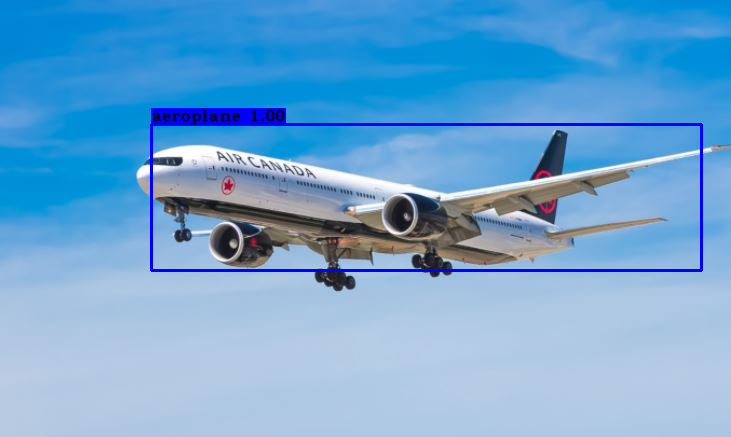

In [ ]:
load_yolo_weights(yolo, "./model_data/yolov3.weights") # use Darknet weights
img = detect_image(yolo, image_path, "", input_size=input_size, show=True, CLASSES=YOLO_COCO_CLASSES, rectangle_colors=(255,0,0))
cv2_imshow(img)